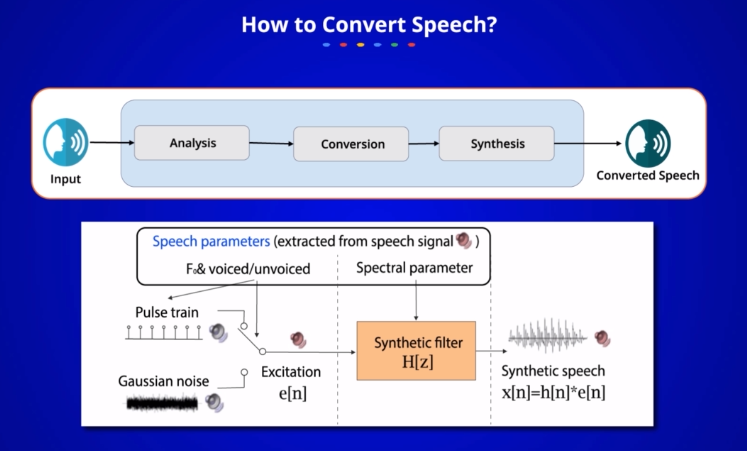

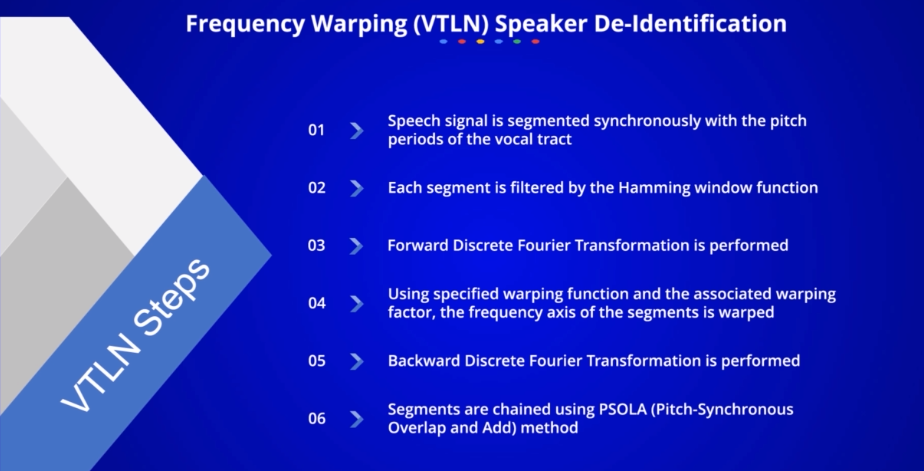

# Import the required packages

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import librosa

# Get the data directories

In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/Speaker Identification/speeches_dataset.zip'

In [2]:
data_dir = "16000_pcm_speeches/"
os.listdir(data_dir)

['Benjamin_Netanyau',
 'Jens_Stoltenberg',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela',
 'other',
 'tf_Wav_reader.py',
 '_background_noise_']

# Process training dataset

In [3]:
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [4]:
nelson_mandela_paths = get_wav_paths("Nelson_Mandela")
margaret_thatcher_paths = get_wav_paths("Magaret_Tarcher")
benjamin_netanyau_paths = get_wav_paths("Benjamin_Netanyau")
jens_stoltenberg_paths = get_wav_paths( 'Jens_Stoltenberg')
julia_gillard_paths = get_wav_paths("Julia_Gillard")

noise1_paths = get_wav_paths("_background_noise_")
noise2_paths = get_wav_paths("other")

### load the data

In [5]:
def load_wav(wav_path, speaker):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_path = data_dir + speaker + "/" + wav_path
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
            wav_decoder, feed_dict={
                wav_filename_placeholder: wav_path
            }).audio.flatten().reshape((1, 16000))
        sess.close()
    return wav_data

### create training data

In [6]:
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        wavs.append(wav)
        labels.append(label)
    return wavs, labels

In [7]:
nelson_mandela_wavs, nelson_mandela_labels = generate_training_data(nelson_mandela_paths, "Nelson_Mandela", 0) 
margaret_thatcher_wavs, margaret_thatcher_labels = generate_training_data(margaret_thatcher_paths, "Magaret_Tarcher", 1) 
benjamin_netanyau_wavs, benjamin_netanyau_labels = generate_training_data(benjamin_netanyau_paths, "Benjamin_Netanyau", 2) 
jens_stoltenberg_wavs, jens_stoltenberg_labels = generate_training_data(jens_stoltenberg_paths, "Jens_Stoltenberg", 3) 
julia_gillard_wavs, julia_gillard_labels = generate_training_data(julia_gillard_paths, "Julia_Gillard", 4) 

100%|██████████████████████████████████████████████████████████████████████████████| 1501/1501 [00:30<00:00, 50.17it/s]


In [8]:
np.array(nelson_mandela_labels).shape

(1500,)

In [9]:
np.array(nelson_mandela_wavs).shape

(1500, 1, 16000)

## remove the extra wav for Julia Gillard

In [10]:
julia_gillard_labels = julia_gillard_labels[1:]
julia_gillard_wavs = julia_gillard_wavs[1:]

In [11]:
np.array(julia_gillard_labels).shape

(1500,)

In [12]:
all_wavs = nelson_mandela_wavs + margaret_thatcher_wavs + benjamin_netanyau_wavs + jens_stoltenberg_wavs + julia_gillard_wavs
all_labels = nelson_mandela_labels + margaret_thatcher_labels + benjamin_netanyau_labels + jens_stoltenberg_labels + julia_gillard_labels

### Mixing Noise in the training data

In [13]:
from scipy.io.wavfile import read
from scipy.io.wavfile import write
from random import randint

def cut_random_section(noise2, size2):
    size21 = noise2.size
    starting_point2 = randint(0,(noise2.size - size2))
    end_point2 = starting_point2 + size2
    noise_cut_part2 = noise2[starting_point2:end_point2]
    return noise_cut_part2

def mix(audio1, noise1, snr1):
    audio_max = max(audio1)
    if audio_max==0:
        audio_max = int(np.random.uniform(0.7,1)*32767)
    audio1 = audio1*1.
    audio1 = audio1/audio_max
    noise1 = cut_random_section(noise1, audio1.size)
    noise1 = noise1*1.
    noise1 = noise1/max(noise1)
    gain = pow(10,(snr1/10.))
    numerator = np.mean(abs(audio1)**2)
    denominator = numerator/gain
    noise_power = np.mean(abs(noise1)**2)
    mult_value = (denominator/noise_power)**0.5
    noisy1 = audio1 + noise1*mult_value
    if max(audio1)==0:
        noisy1 = noise1
    else:    
        noisy1 = noisy1/max(noisy1)
    noisy1 = np.array(noisy1*audio_max, dtype='int16')
    return noise1*mult_value, mult_value, noisy1

noise_wavs = []
noise_labels = []
snr_dB = 10
for i in range(len(all_wavs)):
    for noise in os.listdir(data_dir + 'other'):
        fs, noise_file = read(data_dir + 'other/' + noise)
        x = all_wavs[i][0]
        noise_temp, mult_value, noisy = mix(x, noise_file, snr_dB)
        if noisy.any() != 0:
            noise_wavs.append(noisy)
            noise_labels.append(all_labels[i])
    for noise in os.listdir(data_dir + '_background_noise_'):
        fs, noise_file = read(data_dir + '_background_noise_/' + noise)
        x = all_wavs[i][0]
        if len(noise_file.shape) > 1:
            noise_file = np.reshape(noise_file, (noise_file.shape[0]*noise_file.shape[1]))
        noise_temp, mult_value, noisy = mix(x, noise_file, snr_dB)
        if noisy.any() != 0:
            noise_wavs.append(noisy)
            noise_labels.append(all_labels[i]) 
    if i%200 == 0:
        print(i)

D:\Users\elain\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400


In [14]:
for i in range(len(all_wavs)):
    noise_labels.append(all_labels[i])
    noise_wavs.append(all_wavs[i][0])
    
final_wavs = np.array(noise_wavs)
final_labels = np.array(noise_labels)

print(final_wavs.shape,final_labels.shape)

(8170, 16000) (8170,)


# split the dataset into trainin and testing set\

In [15]:
train_wavs,test_wavs,train_labels,test_labels = train_test_split(final_wavs,final_labels,test_size = 0.1)

In [16]:
train_x,train_y = np.array(train_wavs),np.array(train_labels)
test_x,test_y = np.array(test_wavs),np.array(test_labels)

In [17]:
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [18]:
train_y.shape

(7353, 5)

# MFCC Feature Extraction

In [19]:

train_x_new = []
test_x_new = []
INPUT_SHAPE = (126,40)

train_x_new = np.zeros((train_x.shape[0], INPUT_SHAPE[0], INPUT_SHAPE[1]), dtype=np.float64)

count = 0
for sample in train_x:
    mfcc = librosa.feature.mfcc(y=sample, sr=16000, hop_length=128, n_fft=256, n_mfcc=20)
    mfcc_delta = librosa.feature.delta(mfcc)[:10, :]
    mfcc_double_delta = librosa.feature.delta(mfcc, order=2)[:10, :]
    train_x_new[count, :, :20] = mfcc.T
    train_x_new[count, :, 20:30] = mfcc_delta.T
    train_x_new[count, :, 30:] = mfcc_double_delta.T
    count += 1
    if count%500 == 0:
        print('Train', count)
        
test_x_new = np.zeros((test_x.shape[0], INPUT_SHAPE[0], INPUT_SHAPE[1]), dtype=np.float64)

count = 0
for sample in test_x:
    mfcc = librosa.feature.mfcc(y=sample, sr=16000, hop_length=128, n_fft=256, n_mfcc=20)
    mfcc_delta = librosa.feature.delta(mfcc)[:10, :]
    mfcc_double_delta = librosa.feature.delta(mfcc, order=2)[:10, :]
    test_x_new[count, :, :20] = mfcc.T
    test_x_new[count, :, 20:30] = mfcc_delta.T
    test_x_new[count, :, 30:] = mfcc_double_delta.T
    count += 1
    if count%500 == 0:
        print('Test', count)

D:\Users\elain\Anaconda3\lib\site-packages\librosa\filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


Train 500
Train 1000
Train 1500
Train 2000
Train 2500
Train 3000
Train 3500
Train 4000
Train 4500
Train 5000
Train 5500
Train 6000
Train 6500
Train 7000
Test 500


In [20]:
train_x_new = np.expand_dims(train_x_new,axis = 3)
test_x_new = np.expand_dims(test_x_new,axis = 3)
print(train_x_new.shape,test_x_new.shape)

(7353, 126, 40, 1) (817, 126, 40, 1)


# Create a simple model

In [21]:
# create a model
def create_model(speech_feature):
    model = tf.keras.Sequential()
    if speech_feature == "spectrogram":
        model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=(1, 16000),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
    elif speech_feature == "melspectrogram":
        model.add(Melspectrogram(sr=16000, n_mels=128,n_dft=512, n_hop=256,
                            input_shape=(1 , 16000),return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))
        
    elif speech_feature == "mfcc":
        model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu", input_shape=(126,40,1)))
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
#         model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        model.add(tf.keras.layers.Flatten())        
        model.add(tf.keras.layers.Dense(5, activation="softmax"))
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4)
                , loss = "categorical_crossentropy"
                , metrics = ["accuracy"])
        return model

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4)
            , loss = "categorical_crossentropy"
            , metrics = ["accuracy"])
    return model

# mfcc model

In [22]:
model = create_model("mfcc")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 38, 128)      1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 19, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 17, 64)        73792     
_________________________________________________________________
flatten (Flatten)            (None, 65280)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 326405    
Total params: 401,477
Trainable params: 401,477
Non-trainable params: 0
_________________________________________________________________


# Fitting the Model

In [23]:
model.fit(x = train_x_new,y = train_y,epochs=5,validation_data=(test_x_new,test_y))

Epoch 1/5


186/230 [=======================>......] - ETA: 0s - loss: 2.8934 - accuracy: 0.18 - ETA: 29s - loss: 13.7744 - accuracy: 0.18 - ETA: 43s - loss: 14.2276 - accuracy: 0.21 - ETA: 46s - loss: 15.6006 - accuracy: 0.21 - ETA: 48s - loss: 14.9759 - accuracy: 0.20 - ETA: 49s - loss: 13.6412 - accuracy: 0.21 - ETA: 52s - loss: 13.3023 - accuracy: 0.20 - ETA: 53s - loss: 12.3556 - accuracy: 0.23 - ETA: 53s - loss: 11.3611 - accuracy: 0.25 - ETA: 53s - loss: 10.4741 - accuracy: 0.25 - ETA: 53s - loss: 9.9390 - accuracy: 0.2557 - ETA: 53s - loss: 9.3185 - accuracy: 0.263 - ETA: 53s - loss: 8.8382 - accuracy: 0.266 - ETA: 53s - loss: 8.4106 - accuracy: 0.263 - ETA: 53s - loss: 8.0587 - accuracy: 0.264 - ETA: 53s - loss: 7.6693 - accuracy: 0.275 - ETA: 52s - loss: 7.3502 - accuracy: 0.272 - ETA: 52s - loss: 7.0449 - accuracy: 0.276 - ETA: 52s - loss: 6.7750 - accuracy: 0.284 - ETA: 52s - loss: 6.5269 - accuracy: 0.295 - ETA: 52s - loss: 6.2893 - accuracy: 0.294 - ETA: 52s - loss: 6.0780 - accuracy

230/230 [==============================] - ETA: 11s - loss: 1.1415 - accuracy: 0.780 - ETA: 11s - loss: 1.1373 - accuracy: 0.780 - ETA: 11s - loss: 1.1326 - accuracy: 0.781 - ETA: 10s - loss: 1.1294 - accuracy: 0.781 - ETA: 10s - loss: 1.1250 - accuracy: 0.782 - ETA: 10s - loss: 1.1201 - accuracy: 0.783 - ETA: 9s - loss: 1.1175 - accuracy: 0.784 - ETA: 9s - loss: 1.1146 - accuracy: 0.78 - ETA: 9s - loss: 1.1096 - accuracy: 0.78 - ETA: 9s - loss: 1.1050 - accuracy: 0.78 - ETA: 8s - loss: 1.1009 - accuracy: 0.78 - ETA: 8s - loss: 1.0988 - accuracy: 0.78 - ETA: 8s - loss: 1.0959 - accuracy: 0.78 - ETA: 8s - loss: 1.0923 - accuracy: 0.78 - ETA: 7s - loss: 1.0881 - accuracy: 0.78 - ETA: 7s - loss: 1.0854 - accuracy: 0.78 - ETA: 7s - loss: 1.0820 - accuracy: 0.78 - ETA: 7s - loss: 1.0777 - accuracy: 0.78 - ETA: 6s - loss: 1.0740 - accuracy: 0.78 - ETA: 6s - loss: 1.0701 - accuracy: 0.78 - ETA: 6s - loss: 1.0668 - accuracy: 0.78 - ETA: 5s - loss: 1.0638 - accuracy: 0.78 - ETA: 5s - loss: 1.06

186/230 [=======================>......] - ETA: 0s - loss: 0.1568 - accuracy: 0.93 - ETA: 39s - loss: 0.2214 - accuracy: 0.921 - ETA: 46s - loss: 0.3361 - accuracy: 0.885 - ETA: 50s - loss: 0.2836 - accuracy: 0.898 - ETA: 52s - loss: 0.2934 - accuracy: 0.906 - ETA: 56s - loss: 0.2707 - accuracy: 0.911 - ETA: 57s - loss: 0.2505 - accuracy: 0.915 - ETA: 57s - loss: 0.2366 - accuracy: 0.921 - ETA: 57s - loss: 0.2307 - accuracy: 0.916 - ETA: 59s - loss: 0.2328 - accuracy: 0.918 - ETA: 59s - loss: 0.2307 - accuracy: 0.920 - ETA: 58s - loss: 0.2435 - accuracy: 0.916 - ETA: 58s - loss: 0.2351 - accuracy: 0.920 - ETA: 58s - loss: 0.2265 - accuracy: 0.924 - ETA: 58s - loss: 0.2312 - accuracy: 0.918 - ETA: 57s - loss: 0.2229 - accuracy: 0.921 - ETA: 57s - loss: 0.2341 - accuracy: 0.917 - ETA: 57s - loss: 0.2291 - accuracy: 0.920 - ETA: 56s - loss: 0.2254 - accuracy: 0.921 - ETA: 56s - loss: 0.2311 - accuracy: 0.920 - ETA: 56s - loss: 0.2308 - accuracy: 0.919 - ETA: 56s - loss: 0.2249 - accuracy:

230/230 [==============================] - ETA: 11s - loss: 0.2067 - accuracy: 0.923 - ETA: 11s - loss: 0.2068 - accuracy: 0.923 - ETA: 11s - loss: 0.2063 - accuracy: 0.923 - ETA: 11s - loss: 0.2058 - accuracy: 0.923 - ETA: 10s - loss: 0.2058 - accuracy: 0.923 - ETA: 10s - loss: 0.2058 - accuracy: 0.924 - ETA: 10s - loss: 0.2064 - accuracy: 0.923 - ETA: 10s - loss: 0.2056 - accuracy: 0.924 - ETA: 9s - loss: 0.2052 - accuracy: 0.924 - ETA: 9s - loss: 0.2052 - accuracy: 0.92 - ETA: 9s - loss: 0.2046 - accuracy: 0.92 - ETA: 8s - loss: 0.2048 - accuracy: 0.92 - ETA: 8s - loss: 0.2046 - accuracy: 0.92 - ETA: 8s - loss: 0.2040 - accuracy: 0.92 - ETA: 8s - loss: 0.2039 - accuracy: 0.92 - ETA: 7s - loss: 0.2031 - accuracy: 0.92 - ETA: 7s - loss: 0.2031 - accuracy: 0.92 - ETA: 7s - loss: 0.2029 - accuracy: 0.92 - ETA: 6s - loss: 0.2031 - accuracy: 0.92 - ETA: 6s - loss: 0.2031 - accuracy: 0.92 - ETA: 6s - loss: 0.2039 - accuracy: 0.92 - ETA: 6s - loss: 0.2036 - accuracy: 0.92 - ETA: 5s - loss: 

186/230 [=======================>......] - ETA: 0s - loss: 0.2552 - accuracy: 0.90 - ETA: 39s - loss: 0.2148 - accuracy: 0.921 - ETA: 53s - loss: 0.2297 - accuracy: 0.916 - ETA: 57s - loss: 0.1905 - accuracy: 0.929 - ETA: 58s - loss: 0.1880 - accuracy: 0.925 - ETA: 1:01 - loss: 0.1851 - accuracy: 0.92 - ETA: 1:02 - loss: 0.1871 - accuracy: 0.92 - ETA: 1:01 - loss: 0.1696 - accuracy: 0.93 - ETA: 1:01 - loss: 0.1803 - accuracy: 0.93 - ETA: 1:01 - loss: 0.1747 - accuracy: 0.94 - ETA: 1:01 - loss: 0.1749 - accuracy: 0.94 - ETA: 1:01 - loss: 0.1668 - accuracy: 0.94 - ETA: 1:00 - loss: 0.1606 - accuracy: 0.94 - ETA: 1:00 - loss: 0.1516 - accuracy: 0.95 - ETA: 1:00 - loss: 0.1456 - accuracy: 0.95 - ETA: 59s - loss: 0.1453 - accuracy: 0.9531 - ETA: 59s - loss: 0.1431 - accuracy: 0.952 - ETA: 59s - loss: 0.1437 - accuracy: 0.949 - ETA: 58s - loss: 0.1542 - accuracy: 0.945 - ETA: 58s - loss: 0.1513 - accuracy: 0.945 - ETA: 57s - loss: 0.1516 - accuracy: 0.946 - ETA: 57s - loss: 0.1464 - accuracy

230/230 [==============================] - ETA: 12s - loss: 0.1531 - accuracy: 0.941 - ETA: 11s - loss: 0.1529 - accuracy: 0.941 - ETA: 11s - loss: 0.1531 - accuracy: 0.941 - ETA: 11s - loss: 0.1532 - accuracy: 0.941 - ETA: 11s - loss: 0.1535 - accuracy: 0.940 - ETA: 10s - loss: 0.1536 - accuracy: 0.940 - ETA: 10s - loss: 0.1532 - accuracy: 0.940 - ETA: 10s - loss: 0.1533 - accuracy: 0.940 - ETA: 9s - loss: 0.1543 - accuracy: 0.940 - ETA: 9s - loss: 0.1542 - accuracy: 0.94 - ETA: 9s - loss: 0.1548 - accuracy: 0.94 - ETA: 9s - loss: 0.1549 - accuracy: 0.94 - ETA: 8s - loss: 0.1548 - accuracy: 0.94 - ETA: 8s - loss: 0.1542 - accuracy: 0.94 - ETA: 8s - loss: 0.1550 - accuracy: 0.94 - ETA: 7s - loss: 0.1548 - accuracy: 0.94 - ETA: 7s - loss: 0.1542 - accuracy: 0.94 - ETA: 7s - loss: 0.1548 - accuracy: 0.94 - ETA: 7s - loss: 0.1557 - accuracy: 0.93 - ETA: 6s - loss: 0.1558 - accuracy: 0.93 - ETA: 6s - loss: 0.1553 - accuracy: 0.94 - ETA: 6s - loss: 0.1548 - accuracy: 0.94 - ETA: 5s - loss: 

186/230 [=======================>......] - ETA: 0s - loss: 0.3200 - accuracy: 0.87 - ETA: 33s - loss: 0.2906 - accuracy: 0.890 - ETA: 43s - loss: 0.2310 - accuracy: 0.916 - ETA: 49s - loss: 0.2328 - accuracy: 0.898 - ETA: 51s - loss: 0.2568 - accuracy: 0.881 - ETA: 53s - loss: 0.2484 - accuracy: 0.885 - ETA: 54s - loss: 0.2399 - accuracy: 0.883 - ETA: 54s - loss: 0.2372 - accuracy: 0.886 - ETA: 55s - loss: 0.2284 - accuracy: 0.892 - ETA: 55s - loss: 0.2168 - accuracy: 0.900 - ETA: 55s - loss: 0.2068 - accuracy: 0.903 - ETA: 55s - loss: 0.2128 - accuracy: 0.901 - ETA: 55s - loss: 0.2163 - accuracy: 0.901 - ETA: 55s - loss: 0.2146 - accuracy: 0.904 - ETA: 55s - loss: 0.2023 - accuracy: 0.910 - ETA: 55s - loss: 0.1982 - accuracy: 0.914 - ETA: 55s - loss: 0.1976 - accuracy: 0.915 - ETA: 55s - loss: 0.1925 - accuracy: 0.918 - ETA: 55s - loss: 0.1895 - accuracy: 0.921 - ETA: 55s - loss: 0.1885 - accuracy: 0.920 - ETA: 54s - loss: 0.1836 - accuracy: 0.922 - ETA: 54s - loss: 0.1809 - accuracy:

230/230 [==============================] - ETA: 11s - loss: 0.1364 - accuracy: 0.945 - ETA: 11s - loss: 0.1360 - accuracy: 0.945 - ETA: 11s - loss: 0.1355 - accuracy: 0.946 - ETA: 11s - loss: 0.1349 - accuracy: 0.946 - ETA: 10s - loss: 0.1358 - accuracy: 0.946 - ETA: 10s - loss: 0.1359 - accuracy: 0.946 - ETA: 10s - loss: 0.1361 - accuracy: 0.946 - ETA: 10s - loss: 0.1356 - accuracy: 0.946 - ETA: 9s - loss: 0.1359 - accuracy: 0.946 - ETA: 9s - loss: 0.1370 - accuracy: 0.94 - ETA: 9s - loss: 0.1366 - accuracy: 0.94 - ETA: 8s - loss: 0.1377 - accuracy: 0.94 - ETA: 8s - loss: 0.1375 - accuracy: 0.94 - ETA: 8s - loss: 0.1379 - accuracy: 0.94 - ETA: 8s - loss: 0.1384 - accuracy: 0.94 - ETA: 7s - loss: 0.1381 - accuracy: 0.94 - ETA: 7s - loss: 0.1379 - accuracy: 0.94 - ETA: 7s - loss: 0.1387 - accuracy: 0.94 - ETA: 7s - loss: 0.1389 - accuracy: 0.94 - ETA: 6s - loss: 0.1384 - accuracy: 0.94 - ETA: 6s - loss: 0.1379 - accuracy: 0.94 - ETA: 6s - loss: 0.1382 - accuracy: 0.94 - ETA: 5s - loss: 

186/230 [=======================>......] - ETA: 0s - loss: 0.0464 - accuracy: 0.96 - ETA: 31s - loss: 0.0328 - accuracy: 0.984 - ETA: 42s - loss: 0.0814 - accuracy: 0.968 - ETA: 48s - loss: 0.0670 - accuracy: 0.976 - ETA: 51s - loss: 0.1222 - accuracy: 0.943 - ETA: 53s - loss: 0.1420 - accuracy: 0.932 - ETA: 54s - loss: 0.1358 - accuracy: 0.942 - ETA: 55s - loss: 0.1358 - accuracy: 0.941 - ETA: 55s - loss: 0.1371 - accuracy: 0.941 - ETA: 55s - loss: 0.1477 - accuracy: 0.937 - ETA: 55s - loss: 0.1540 - accuracy: 0.934 - ETA: 56s - loss: 0.1535 - accuracy: 0.937 - ETA: 56s - loss: 0.1515 - accuracy: 0.939 - ETA: 56s - loss: 0.1489 - accuracy: 0.939 - ETA: 56s - loss: 0.1493 - accuracy: 0.939 - ETA: 56s - loss: 0.1422 - accuracy: 0.943 - ETA: 55s - loss: 0.1472 - accuracy: 0.937 - ETA: 56s - loss: 0.1499 - accuracy: 0.935 - ETA: 56s - loss: 0.1546 - accuracy: 0.932 - ETA: 55s - loss: 0.1524 - accuracy: 0.934 - ETA: 55s - loss: 0.1543 - accuracy: 0.933 - ETA: 55s - loss: 0.1502 - accuracy:

230/230 [==============================] - ETA: 12s - loss: 0.1265 - accuracy: 0.947 - ETA: 11s - loss: 0.1260 - accuracy: 0.948 - ETA: 11s - loss: 0.1263 - accuracy: 0.947 - ETA: 11s - loss: 0.1265 - accuracy: 0.947 - ETA: 10s - loss: 0.1265 - accuracy: 0.947 - ETA: 10s - loss: 0.1269 - accuracy: 0.947 - ETA: 10s - loss: 0.1264 - accuracy: 0.947 - ETA: 10s - loss: 0.1262 - accuracy: 0.947 - ETA: 9s - loss: 0.1261 - accuracy: 0.947 - ETA: 9s - loss: 0.1262 - accuracy: 0.94 - ETA: 9s - loss: 0.1264 - accuracy: 0.94 - ETA: 9s - loss: 0.1260 - accuracy: 0.94 - ETA: 8s - loss: 0.1257 - accuracy: 0.94 - ETA: 8s - loss: 0.1258 - accuracy: 0.94 - ETA: 8s - loss: 0.1260 - accuracy: 0.94 - ETA: 7s - loss: 0.1261 - accuracy: 0.94 - ETA: 7s - loss: 0.1259 - accuracy: 0.94 - ETA: 7s - loss: 0.1259 - accuracy: 0.94 - ETA: 7s - loss: 0.1260 - accuracy: 0.94 - ETA: 6s - loss: 0.1261 - accuracy: 0.94 - ETA: 6s - loss: 0.1260 - accuracy: 0.94 - ETA: 6s - loss: 0.1254 - accuracy: 0.94 - ETA: 5s - loss: 

# Saving the model to local

In [24]:
model.save('speaker_model.h5')

# Predicting the output and analyzing

In [25]:
y_pred = model.predict(test_x_new)

In [26]:
y_pred.shape

(817, 5)

In [27]:
test_y.shape

(817, 5)

In [28]:
y_pred = np.argmax(y_pred,axis = 1)

In [29]:
test_y = np.argmax(test_y,axis = 1)

In [30]:
confusion_matrix(test_y,y_pred)

array([[158,   0,   1,   2,  13],
       [  3, 158,   0,   3,   3],
       [  2,   1, 136,   1,   5],
       [  0,   1,   0, 147,   3],
       [  5,   1,   2,   4, 168]], dtype=int64)